<a href="https://colab.research.google.com/github/Matvezy/Autoencoder/blob/master/TorchFRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [86]:
colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]

a,b,c=colours[0]

In [87]:
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [88]:
img = Image.open('/content/gdrive/MyDrive/Female/S/1/Front.jpg')
transform = T.Compose([T.ToTensor()])
img = transform(img)
if img.size()[0] == 4:
        img = img[:3, ...] 
pred = model([img])

In [89]:
pred[0]

{'boxes': tensor([[ 163.7035,  231.8671,  767.6579, 1220.7207],
         [  37.7064,  425.9316,  241.8783,  572.5884],
         [  34.1810,  420.0560,  243.2202,  571.7703],
         [ 288.6992,  655.6385,  354.3475,  723.0757],
         [ 353.1827,  273.2408,  634.9679, 1248.9226],
         [ 766.3314,  492.3761,  858.3873,  554.4324],
         [ 236.0710,  655.8040,  379.0254,  878.3633],
         [ 539.2992,  355.3454,  629.5081,  453.9359],
         [ 154.7198,  616.7180,  766.9011,  957.2806],
         [ 536.2884,  468.6349,  613.9143,  539.5218],
         [ 117.2904,  422.2280,  382.1374,  627.9409]], grad_fn=<StackBackward>),
 'labels': tensor([ 1, 72, 78, 85,  1, 72,  1, 27, 15, 81, 78]),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
     

In [90]:
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks.shape

(11, 1280, 960)

In [91]:
print(masks)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

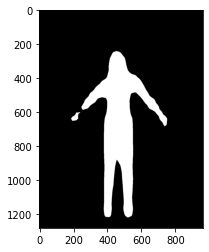

In [92]:
plt.imshow(masks[0], cmap='gray')
plt.show()

(1280, 960, 3)


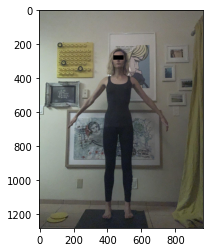

In [93]:
import matplotlib.image as mpimg
image=mpimg.imread('/content/gdrive/MyDrive/Female/S/1/Front.jpg')
if image.shape[-1] == 4:
        image = image[..., :3]
print(image.shape)
plt.imshow(image)
plt.show()

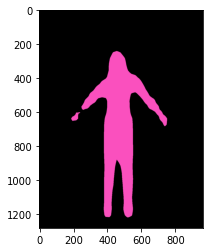

In [94]:
mask1 = random_colour_masks(masks[0])
#mask1 = np.asarray(mask1, np.float32)
plt.imshow(mask1); plt.show()

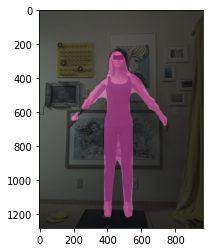

In [95]:
masked1 = cv2.addWeighted(image, 0.5, mask1, 0.5, 0)

plt.imshow(masked1)